## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Unsupervised Learning - Matrix Completion

In [1]:
# !pip install tensorflow
# !pip install fancyimpute

import tensorflow as tf  # fancyimpute uses tensorflow, we'll explicitly load it so that's clear
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from fancyimpute import SimpleFill, KNN, MatrixFactorization

%matplotlib inline
plt.style.use("ggplot")

tf.random.set_seed(0)
np.random.seed(0)

## Synthetic Data
First, let us create some synthetic data that we are going to use to test out a variety of matrix completion algorithms. Note that we force the data in $X$ to have a low rank. 

In [2]:
# Create the data matrix X
# If you think of this as a recommendation engine
# Select n as the number of users
n = 100 
# Select m as the number of movies or products
m = 50
# Select the inner_rank as the number of real genres or categories that movies or products belong to
inner_rank = 10
user_matrix = np.random.randn(n, inner_rank)
item_matrix = np.random.randn(inner_rank, m)
# X = np.dot(np.random.randn(n, inner_rank), np.random.randn(inner_rank, m))
# X = np.dot(user_matrix, item_matrix)
X = user_matrix @ item_matrix

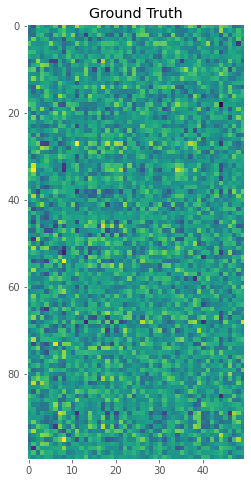

In [3]:
# Let's visualize the matrix X
plt.figure(figsize=(4, 8))
plt.imshow(X)
plt.grid(False)
plt.title("Ground Truth")
plt.show()

Here we've essentially created a matrix that represents the ground truth of how much each person really likes each product. Now in reality, we don't actually have access to that matrix. We have access to a very tiny view of this matrix because our users don't usually review products to let us know what they like.

## Removing Data From $X$
Since we are studying matrix completion algorithms we need to have some missing values! To do this we will randomly remove some data from $X$. 

Remember... since $X$ can be represented by an `inner_rank` of linearly independent columns it should be relatively easy for a matrix completion algorithm to reconstruct the missing data.

In [4]:
# What percent of user-movie combinations do we have access to?
# For now we'll select an easier case but you can come back and change this value to see how the model performs
visible_percentage = 0.6
missing_mask = np.random.rand(*X.shape) < (1 - visible_percentage)
X_incomplete = X.copy()
# missing entries indicated with NaN
X_incomplete[missing_mask] = np.nan

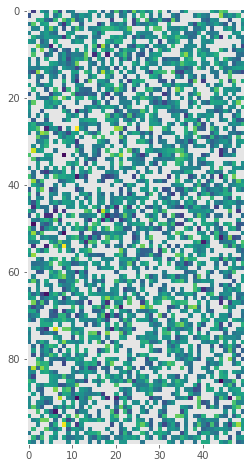

In [5]:
# Let's visualize the data matrix X_incomplete
plt.figure(figsize=(4, 8))
plt.imshow(X_incomplete)
plt.grid(False)
plt.show()

## Matrix Completion
Now, given the incomplete matrix `X_incomplete` we want to try and fill in the missing values. For this we are going to use the https://github.com/iskandr/fancyimpute package in Python.

For the first example, I will provide an example implementation where we fill in all the missing values using `SimpleFill`:

In [6]:
meanFill = SimpleFill("mean")
X_filled_mean = meanFill.fit_transform(X_incomplete)

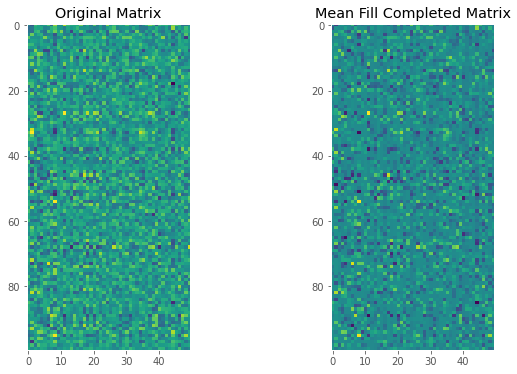

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.imshow(X)
ax1.set_title("Original Matrix")
ax1.grid(False)

ax2.imshow(X_filled_mean)
ax2.set_title("Mean Fill Completed Matrix")
ax2.grid(False)
plt.show()

In [8]:
# To test the performance of our matrix completion algorithm we want to compare
# the "filled-in" values to the original:
def mat_completion_mse(X_filled, X_truth, missing_mask):
    """Calculates the mean squared error of the filled in values vs. the truth
    
    Args:
        X_filled (np.ndarray): The "filled-in" matrix from a matrix completion algorithm
        X_truth (np.ndarray): The true filled in matrix
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        float: Mean squares error of the filled values
    """
    return ((X_filled[missing_mask] - X_truth[missing_mask]) ** 2).mean()

In [9]:
meanFill_mse = mat_completion_mse(X_filled_mean, X, missing_mask)
print("meanFill MSE: %f" % meanFill_mse)

meanFill MSE: 9.040554


### KNN Completion
Next you will use the K-Nearest Neighbors algorithm to fill in the missing values. First, we will need to find the best number of neighbors to use for the KNN algorithm:

In [10]:
# Find the best value for k
def find_best_k(k_neighbors, complete_mat, incomplete_mat, missing_mask):
    """Determines the best k to use for matrix completion with KNN
    
    Args:
        k_neighbors (iterable): The list of k's to try
        complete_mat (np.ndarray): The original matrix with complete values
        incomplete_mat (np.ndarray): The matrix with missing values
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        integer: the best value of k to use for that particular matrix
    """

    metrics = []
    for neighbors in k_neighbors:
        knn_filled = KNN(k=neighbors).fit_transform(incomplete_mat)
        knn_mse = mat_completion_mse(knn_filled, complete_mat, missing_mask)
        metrics.append((neighbors, knn_mse))
    # find minimum using the [1] index of each tuple... in the line above its obvious the tuple is just (k, mse), perhaps the if statement every loop is better but I am not too sure. 
    best_k = min(metrics, key=lambda item:item[1])[0]
    return best_k

In [11]:
k_neighbors = [2, 3, 4, 5, 10, 20]
best_k = find_best_k(k_neighbors, X, X_incomplete, missing_mask)

Imputing row 1/100 with 21 missing, elapsed time: 0.015
Imputing row 1/100 with 21 missing, elapsed time: 0.009
Imputing row 1/100 with 21 missing, elapsed time: 0.008
Imputing row 1/100 with 21 missing, elapsed time: 0.008
Imputing row 1/100 with 21 missing, elapsed time: 0.017
Imputing row 1/100 with 21 missing, elapsed time: 0.013


In [12]:
best_k

5

In [13]:
assert best_k == 5

Now that we have found the `best_k` to use let's see how well it performed:

In [14]:
# Run KNN with the best_k and store the result in X_filled_knn

# YOUR CODE HERE
X_filled_knn = KNN(k=best_k).fit_transform(X_incomplete)

knnFill_mse = mat_completion_mse(X_filled_knn, X, missing_mask)
print("knnFill MSE: %f" % knnFill_mse)

Imputing row 1/100 with 21 missing, elapsed time: 0.018
knnFill MSE: 4.391079


In [15]:
assert knnFill_mse < meanFill_mse

## Visually Comparison of Matrix Completion Algorithms
To get a good idea of how these matrix completion algorithms compare we want to create a method that visualizes how well these algorithms actually perform.

#### Creating a Collection of Models
Now we create a handful of matrix completion algorithms that we want to visualize:
 - Mean Fill
 - K-Nearest Neighbors
 - MatrixFactorization (an implementaiton using gradient descent)

In [16]:
simpleFill = SimpleFill("mean")
knnFill = KNN(k=best_k)
mfFill = MatrixFactorization(learning_rate=0.01, rank=20, l2_penalty=0, min_improvement=1e-6, optimization_algorithm="Nadam")
methods = [simpleFill, knnFill, mfFill]
names = ["SimpleFill", "KNN", "MatFactor"]

In [17]:
def mat_completion_comparison(methods, incomplete_mat, complete_mat, missing_mask):
    """Using a list of provided matrix completion methods calculate 
    the completed matrix and the determine the associated 
    mean-squared-error results.
    
    Args:
        methods (iterable): A list of matrix completion algorithms
        incomplete_mat (np.ndarray): The incomplete matrix
        complete_mat (np.ndarray): The full matrix
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        filled_mats (iterable): the "filled-in" matrices
        mses (iterable): the mean square error results
    """
    X_filled_mats = []
    mses = []
    # knn_filled = KNN(k=neighbors).fit_transform(incomplete_mat)
    # knn_mse = mat_completion_mse(knn_filled, complete_mat, missing_mask)
    for method in methods:
        # YOUR CODE HERE
        mat = method.fit_transform(incomplete_mat)
        X_filled_mats.append(mat)
        mses.append(mat_completion_mse(mat, complete_mat, missing_mask))

    return X_filled_mats, mses

The autograder test below may take a minute or so to run.

You can ignore any warnings about `lr` or `learning_rate`.

In [18]:
X_filled_mats, mses = mat_completion_comparison(methods, X_incomplete, X, missing_mask)
assert len(X_filled_mats) == len(methods)
assert len(mses) == len(methods)

Imputing row 1/100 with 21 missing, elapsed time: 0.010


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 1.0597 - val_loss: 1.0305
Epoch 2/10000
1/1 [==============================] - 0s 26ms/step - loss: 1.0284 - val_loss: 1.0287
Epoch 3/10000
1/1 [==============================] - 0s 25ms/step - loss: 1.0067 - val_loss: 1.0282
Epoch 4/10000
1/1 [==============================] - 0s 25ms/step - loss: 0.9871 - val_loss: 1.0268
Epoch 5/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.9679 - val_loss: 1.0261
Epoch 6/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.9486 - val_loss: 1.0245
Epoch 7/10000
1/1 [==============================] - 0s 28ms/step - loss: 0.9288 - val_loss: 1.0232
Epoch 8/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.9085 - val_loss: 1.0205
Epoch 9/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.8875 - val_loss: 1.0181
Epoch 10/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.8657 - val_loss: 1.0136
E

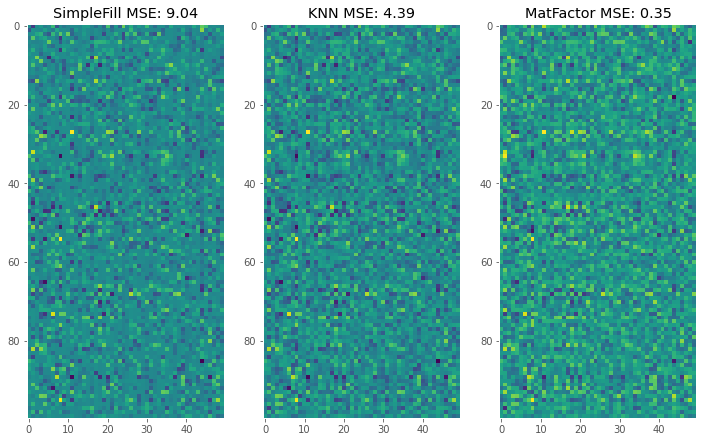

In [19]:
plt.figure(figsize=(12, 8)) # Change the figure size to your liking

for i in range(0, len(methods)):
    X_filled = X_filled_mats[i]
    mse = mses[i]
    ax = plt.subplot(131 + i)
    ax.imshow(X_filled)
    ax.title.set_text(f'{names[i]} MSE: {mse:0.2f}')
    ax.grid(False)
    
plt.show()

## Feedback

In [20]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return 'N/A, activity was fine'